In [20]:
import os
os.chdir("/home2/jgcw74/l3_project")  # go to project root
import importlib
import helpers

import dataset_processing
import models
import xai
importlib.reload(xai.shap_method)

torch_device = helpers.utils.get_torch_device(force_mps=True)

In [115]:
import typing as t
from pathlib import Path
import json

import torch
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

## Load in results

In [3]:
dfs = dict()
for explainer_name in t.get_args(xai.EXPLAINER_NAMES):
    results_for_exp = dict()
    h5_output_path = helpers.env_var.get_project_root() / "results" / explainer_name / "evaluation_output.h5"
    store = pd.HDFStore(str(h5_output_path), mode="r")
    for key_name in store.keys():
        table_name = key_name.strip("/")
        df: pd.DataFrame = store[table_name]
        if df.isna().sum().sum() != 0:
            raise RuntimeError("A results table contains NaN values!")
        else:
            results_for_exp[table_name] = df
    dfs[explainer_name] = results_for_exp
    store.close()
for key in dfs.keys():
    print(f"{key}: {len(dfs[key])} tables loaded")

PartitionSHAP: 12 tables
GradCAM: 12 tables
KPCACAM: 12 tables


### Try loading some data

In [136]:
model_name = "SwinTransformerSmall"
dataset_name = "PatternNet"

model_type = models.get_model_type(model_name)
dataset = dataset_processing.get_dataset_object(dataset_name, "test", model_type.expected_input_dim, 32, 4, torch_device)
model = model_type(False, dataset.N_BANDS, dataset.N_CLASSES).to(torch_device)

weights_path = json.load(Path("weights_paths.json").open("r"))[dataset_name][model_name]
model.load_weights(Path("checkpoints") / dataset_name / model_name / weights_path)
print(list(enumerate(dataset.classes)))

[(0, 'airplane'), (1, 'baseball_field'), (2, 'basketball_court'), (3, 'beach'), (4, 'bridge'), (5, 'cemetery'), (6, 'chaparral'), (7, 'christmas_tree_farm'), (8, 'closed_road'), (9, 'coastal_mansion'), (10, 'crosswalk'), (11, 'dense_residential'), (12, 'ferry_terminal'), (13, 'football_field'), (14, 'forest'), (15, 'freeway'), (16, 'golf_course'), (17, 'harbor'), (18, 'intersection'), (19, 'mobile_home_park'), (20, 'nursing_home'), (21, 'oil_gas_field'), (22, 'oil_well'), (23, 'overpass'), (24, 'parking_lot'), (25, 'parking_space'), (26, 'railway'), (27, 'river'), (28, 'runway'), (29, 'runway_marking'), (30, 'shipping_yard'), (31, 'solar_panel'), (32, 'sparse_residential'), (33, 'storage_tank'), (34, 'swimming_pool'), (35, 'tennis_court'), (36, 'transformer_station'), (37, 'wastewater_treatment_plant')]


In [137]:
class_idx = 1
batch_num = 0
base_exp = xai.get_explainer_object(
    "PartitionSHAP", model,
    extra_path=Path(dataset_name) / f"c{class_idx:02}" / f"b{batch_num:03}",
)
base_exp.force_load()

Loading input, explanation, and kwargs from /home2/jgcw74/l3_project/xai_output_unix/PatternNet/c01/b000/PartitionSHAP/SwinTransformerSmall.npz...


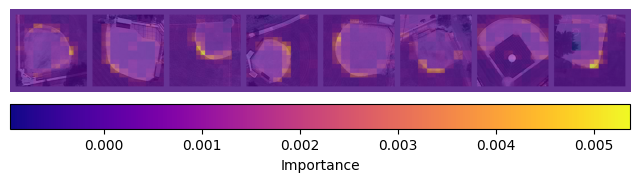

In [144]:
importlib.reload(helpers.plotting)
helpers.plotting.visualise_importance(base_exp.input.numpy(force=True), base_exp.explanation, alpha=0.6, with_colorbar=True)

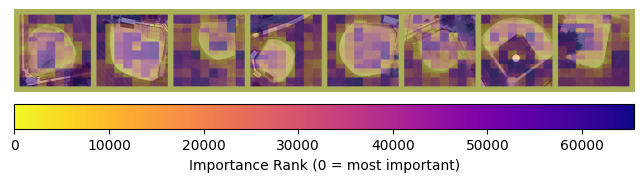

In [145]:
helpers.plotting.visualise_importance(base_exp.input.numpy(force=True), base_exp.ranked_explanation, alpha=0.4, with_colorbar=True)

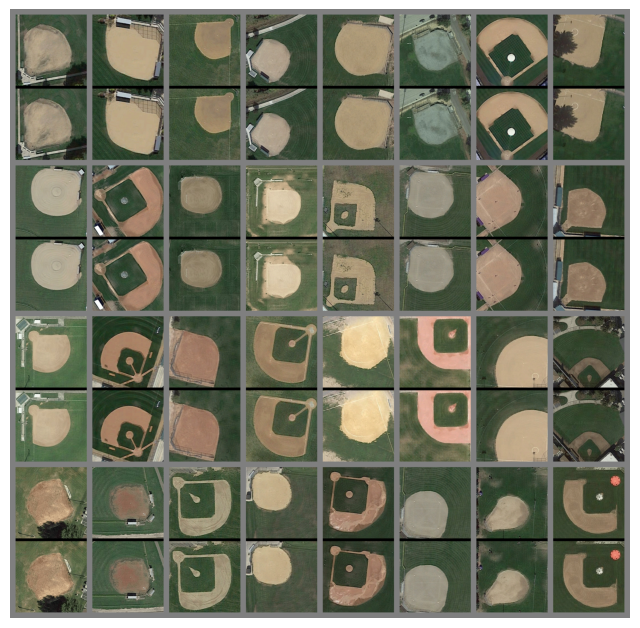

In [139]:
img_dict = np.load(helpers.env_var.get_xai_output_root() /
                   Path(dataset_name) / f"c{class_idx:02}" / "combined" /
                   f"{model_name}_adversarial_examples.npz")
og_imgs = img_dict["original_imgs"]
adv_imgs = img_dict["clipped_adv_imgs"]
helpers.plotting.show_image(
    np.stack([np.hstack([im1, -np.ones((3, 10, im1.shape[-1])), im2]) for im1, im2 in zip(og_imgs, adv_imgs)]),
    padding=20,
)

In [141]:
base_exp.model(torch.from_numpy(og_imgs).to(torch_device)).argmax(1)

tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1], device='cuda:0')

In [142]:
base_exp.model(torch.from_numpy(adv_imgs).to(torch_device)).argmax(1)

tensor([ 8,  1, 16,  1,  8,  1, 13,  2,  1,  1, 33,  1,  2,  1,  1,  2, 13,  1,
         2,  1,  3,  1, 16, 16,  1,  1, 13, 16,  1,  1, 16, 16],
       device='cuda:0')

## Plot evaluation results

In [ ]:
explainer_name = "GradCAM"
h5_output_name = "evaluation_output.h5"
dataset_name = "EuroSATRGB"
model_name = "ConvNeXtSmall"

In [ ]:
h5_output_path = helpers.env_var.get_project_root() / "results" / explainer_name / h5_output_name
if not h5_output_path.parent.exists():
    raise FileNotFoundError(f"Path {h5_output_path.parent} does not exist.")

store = pd.HDFStore(str(h5_output_path))
df_name = f"{dataset_name}_{model_name}"
if df_name not in store:
    raise KeyError(f"Dataframe {df_name} not found in HDF5 file.")
df = store[df_name]

In [ ]:
df

In [ ]:
df["compactness : threshold_score"].plot(kind="bar", rot=90)

In [ ]:
df["continuity : perturbation_similarity : top_k_intersection"].plot(kind="bar", rot=90)

In [ ]:
df["correctness : incremental_deletion_auc_ratio"].plot(kind="bar", rot=90)

In [ ]:
store.close()

In [ ]:
df

In [ ]:
store = pd.HDFStore(str(h5_output_path))
store[df_name] = df
store.close()

In [ ]:
store.close()